In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from IPython.display import display, HTML


# Download data

In [2]:
import json
import os

with open('./kaggle.json') as json_file:
    data = json.load(json_file)
    kaggle_username = data['username']
    api_key = data['key']
    os.environ['KAGGLE_USERNAME'] = kaggle_username
    os.environ['KAGGLE_KEY'] = api_key
    !kaggle competitions download -c sberbank-russian-housing-market

100%|███████████████████████████████████████| 21.6M/21.6M [01:00<00:00, 343kB/s]
100%|███████████████████████████████████████| 21.6M/21.6M [01:00<00:00, 378kB/s]


In [3]:
!unzip -o sberbank-russian-housing-market.zip
!rm sberbank-russian-housing-market.zip
!rm -r sample_data
!unzip -o train.csv.zip
!rm train.csv.zip
!unzip -o macro.csv.zip
!rm macro.csv.zip
!unzip -o sample_submission.csv.zip
!rm sample_submission.csv.zip
!unzip -o test.csv.zip
!rm test.csv.zip
!rm -r __MACOSX

Archive:  sberbank-russian-housing-market.zip
  inflating: data_dictionary.txt     
  inflating: macro.csv.zip           
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           
rm: невозможно удалить 'sample_data': Нет такого файла или каталога
Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  macro.csv.zip
  inflating: macro.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


In [4]:
train = pd.read_csv('./train.csv', index_col='id')
test = pd.read_csv('./test.csv', index_col='id')
train['timestamp'] = train['timestamp'].apply(pd.to_datetime)

In [11]:
def num_houses_with_bigger_column_value (column_name, value):
    return len(train[train[column_name] > value].index)

def num_houses_with_less_column_value (column_name, value):
    return len(train[train[column_name] < value].index)

In [12]:
def plot_feature_kde(column_name, min_value, max_value):
    data = train[column_name]
    data = data.where(data.notnull(), axis=0)
    data = data[(min_value <= data) & (data <= max_value)]
    ax = sns.kdeplot(data=data, shade=True)
    ax.set(xlabel= column_name, ylabel='density')

def plot_regplot(column_name1, column_name2, col1_min, col1_max, col2_min, col2_max, alpha=0.1):
    reg_plot_data = train[[column_name1, column_name2]]
    reg_plot_data = reg_plot_data[(col1_min <= train[column_name1]) & (train[column_name1] <= col1_max) \
                                & (col2_min <= train[column_name2]) & (train[column_name2] <= col2_max)]
    sns.regplot(x=reg_plot_data[column_name1], y=reg_plot_data[column_name2], \
              scatter_kws={'alpha':alpha})

def plot_features_jointplot(column_name1, column_name2, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2]]
    data = data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.jointplot(column_name1, column_name2, data=data, kind="kde", space=0, color="b", \
                scatter_kws={'alpha':alpha})

def plot_lmplot(column_name1, column_name2, hue, col1_min, col1_max, \
                            col2_min, col2_max, alpha=0.1):
    data = train.loc[:, [column_name1, column_name2, hue]]
    data=data[data.notnull().all(axis=1)]
    data = data[(col1_min <= data[column_name1]) & (data[column_name1] <= col1_max) \
              & (col2_min <= data[column_name2]) & (data[column_name2] <= col2_max)]
    sns.lmplot(x=column_name1, y=column_name2, hue=hue, data=data, scatter_kws={'alpha':alpha})

def plot_distplot(column_name):
    sns.distplot(a=train[column_name], kde=False)

## &emsp; Data processing



In [5]:
import math

def change_life_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1 / 0.67:
        return row['life_sq'] - row['full_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['full_sq']
    return row['life_sq']

def change_full_sq (row):
    if row['life_sq'] > 100 and row['life_sq/full_sq'] > 1 / 0.67:
        return row['full_sq']
    elif row['life_sq/full_sq'] > 1.3:
        return row['life_sq']
    elif row['full_sq'] < row['life_sq']:
        return row['life_sq']
    return row['full_sq']

def account_kitch_sq (row):
    if row['kitch_sq'] >= 0 and row['kitch_sq'] < row['full_sq_help']:
        return row['full_sq_help'] - row['kitch_sq']
    return row['life_sq_help']

def custom_pipeline(train):
    train.drop(train[train['full_sq'] > 1000].index, inplace=True)
    train.drop(train[train['build_year'] > 2018].index, inplace=True)
    train.drop([17935], inplace=True)
    
    mean_division_value = 0.67
    
    train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
    train['life_sq/full_sq'].mask(np.isinf(train['life_sq/full_sq']), inplace=True)
    train['life_sq/full_sq'].fillna(mean_division_value, inplace=True)
  
    train.loc[train['life_sq'] > 200, 'life_sq'] = \
                                    train.loc[train['life_sq'] > 200, :].apply(lambda x: \
                                    x['full_sq'] - x['kitch_sq'] if x['kitch_sq'] >= 0 else x['full_sq'], axis=1)

    mean_value = train['life_sq/full_sq'].mean()
    train['life_sq'] = train.apply(lambda x: x['life_sq'] if not pd.isnull(x['life_sq']) \
                                   else x['full_sq'] * mean_value, axis=1)
    
    train_help = train[['full_sq', 'life_sq', 'kitch_sq', 'life_sq/full_sq']].copy()
    train_help['life_sq_help'] = train_help.apply(change_life_sq, axis=1)
    train_help['full_sq_help'] = train_help.apply(change_full_sq, axis=1)
    train_help['life_sq_help'] = train_help.apply(account_kitch_sq, axis=1)
    train_help['life_sq_help'] = train_help.apply(lambda x: x['life_sq_help'] \
                                if not pd.isnull(x['life_sq_help']) else x['full_sq_help'] * mean_value, axis=1)
    train[['full_sq', 'life_sq']] = train_help[['full_sq_help', 'life_sq_help']]
    train.loc[train['life_sq/full_sq'] > 0.9, 'life_sq'] = \
                    train.loc[train['life_sq/full_sq'] > 0.9].apply(lambda x: x['full_sq'] * mean_value, axis=1)
    
    train.loc[:, 'life_sq'] = train.apply(lambda x: math.ceil(x['life_sq']), axis=1)
    train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
    train['full_sq/life_sq'] = 1 / train['life_sq/full_sq']
    train['kitch_sq'] = train.apply(lambda x: x['full_sq'] - x['life_sq'] , axis = 1)
    train['life_sq/kitch_sq'] = (train['life_sq']) / (train['kitch_sq'] + 1)
    
    train_help = train[['kitch_sq', 'life_sq', 'full_sq', 'life_sq/kitch_sq', 'num_room']].copy()
    train_help['life_sq_help'] = train_help.apply(lambda x: x['kitch_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['life_sq'], axis=1)
    train_help['kitch_sq_help'] = train_help.apply(lambda x: x['life_sq'] \
                                        if x['life_sq/kitch_sq'] < x['num_room'] * 1.3 else x['kitch_sq'], axis=1)
    train[['life_sq', 'kitch_sq']]= train_help[['life_sq_help', 'kitch_sq_help']]
    
    train['life_sq/full_sq'] = train['life_sq'] / (train['full_sq'] + 1)
    train['life_sq/kitch_sq'] = train['life_sq'] / (train['kitch_sq'] + 1)
    train['full_sq/life_sq'] = 1 / train['life_sq/full_sq']
    train['kitch_sq/life_sq'] = 1 / train['life_sq/kitch_sq']
    
    train.rename(columns={'kitch_sq' : 'other_sq'}, inplace=True)
    train.loc[:, 'full_sq'] = train.apply(lambda x: round(x['full_sq']), axis=1)
    train.loc[:, 'life_sq'] = train.apply(lambda x: round(x['life_sq']), axis=1)
    train.loc[:, 'other_sq'] = train.apply(lambda x: round(x['other_sq']), axis=1)
    
    return train

In [6]:
train = custom_pipeline(train)

## &emsp; floor, max_floor and build_year

In [7]:
train[['floor', 'max_floor']].describe()

,floor,max_floor
count,30300.000000,20896.000000
mean,7.670990,12.559772
std,5.320027,6.756431
min,0.000000,0.000000
25%,3.000000,9.000000
50%,6.500000,12.000000
75%,11.000000,17.000000
max,77.000000,117.000000


In [8]:
train[['floor', 'max_floor']].median()

floor         6.5
max_floor    12.0
dtype: float64

In [9]:
train[['floor', 'max_floor']].isna().sum()

floor         167
max_floor    9571
dtype: int64

/home/sergei/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'scatter_kws'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


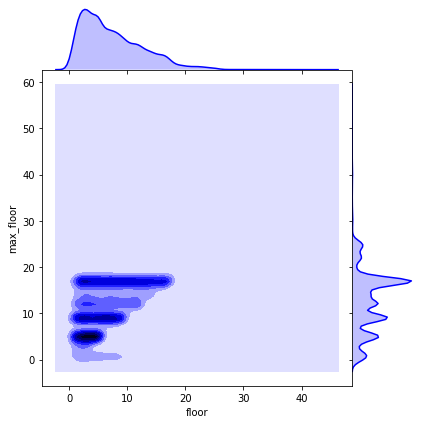

In [13]:
plot_features_jointplot('floor', 'max_floor', 0, 60, 0, 60)

As we can see floors are equally destributed in [0; max_floor].

Also the most popular max_floor values are 5, 9, 12 and 17.

In [14]:
train[train['max_floor'] < train['floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,other_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,full_sq/life_sq,life_sq/kitch_sq,kitch_sq/life_sq
id,,,,,,,,,,,,,,,,,,,,,
8219,2013-05-29,58,58,13.0,0.0,1.0,NaN,2.0,0,NaN,...,7,1,0,12,1,5813760,0.983051,1.017241,58.000000,0.017241
8271,2013-05-31,93,33,3.0,1.0,1.0,2013.0,3.0,60,1.0,...,3,0,0,0,0,5427640,0.351064,2.848485,0.540984,1.848485
8502,2013-06-14,37,37,2.0,0.0,1.0,1979.0,1.0,0,2.0,...,23,1,0,52,5,6000000,0.973684,1.027027,37.000000,0.027027
8534,2013-06-17,34,26,7.0,0.0,6.0,NaN,1.0,8,1.0,...,7,1,0,12,1,3842500,0.742857,1.346154,2.888889,0.346154
8915,2013-07-03,51,43,5.0,0.0,1.0,1997.0,2.0,8,1.0,...,29,1,2,74,11,3850000,0.826923,1.209302,4.777778,0.209302


In [18]:
train[train['max_floor'] < train['floor']].shape[0]

1493

The easiest way to edit this mismatch would be to simply max_floor = floor.
We should also look at interconnection between max_floor and build_year.

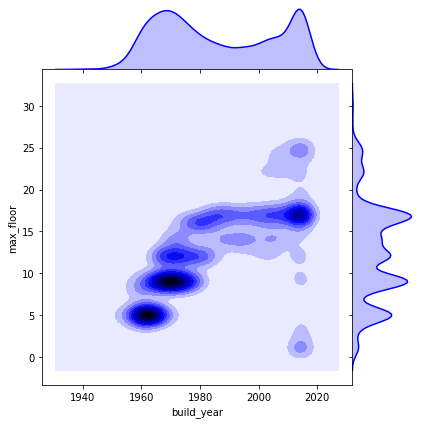

In [15]:
plot_features_jointplot('build_year', 'max_floor', 1940, 2018, 1, 30)

In [16]:
d = dict()
for year in range(1940, 2020, 10):
    print('Year:', year - 10, '-', year, 'median = ', train[(year - 10 <= train['build_year']) \
                                                          & (train['build_year'] < year)]['max_floor'].median())
    d[year] = train[(year - 10 <= train['build_year']) & (train['build_year'] < year)]['max_floor'].median()

Year: 1930 - 1940 median =  5.5
Year: 1940 - 1950 median =  7.0
Year: 1950 - 1960 median =  5.0
Year: 1960 - 1970 median =  8.0
Year: 1970 - 1980 median =  12.0
Year: 1980 - 1990 median =  16.0
Year: 1990 - 2000 median =  16.0
Year: 2000 - 2010 median =  17.0


In [17]:
train[train['build_year'] < 1930]['max_floor'].median()

10.0

That seems extremely strange. Let's fix all the mentioned problems.

In [0]:
train[(pd.isnull(train['build_year']) & (pd.isnull(train['max_floor']) & (pd.isnull(train['floor']))))]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq,back_kitch_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98.0,94.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,Investment,Kurkino,7.792845e+06,21155,0.528252,0.000000,2539,2794.0,4,2733,6620.0,4,0,920.0,0,0,7,1,no,0,4,0,no,no,no,no,no,no,no,no,...,3,4,12,3,1,0,1,2,0,0,7,0,16.36,0.89,5,299940,7,309618,35,911.76,1485.29,1198.53,1,5,8,14,6,1,0,1,3,0,0,10,0,11500000,0.959596,1.042105,19.000000,0.052632
188,2011-10-24,49.0,29.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,...,9,11,6,3,1,0,3,10,0,5,21,5,12.74,24.94,43,1929973,52,2231811,163,633.99,1081.70,857.84,10,50,58,33,10,2,0,9,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37.0,23.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,...,10,11,3,4,1,0,1,11,0,4,18,3,10.64,27.50,80,3045533,43,1958944,177,691.12,1174.56,932.84,8,46,66,39,14,4,0,14,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45.0,27.0,NaN,NaN,NaN,NaN,NaN,18.0,NaN,Investment,Chertanovo Juzhnoe,9.282439e+06,143661,0.153279,0.127376,8356,3844.0,6,8429,8810.0,7,0,NaN,3,0,3,4,no,0,9,3,no,no,no,no,no,no,no,no,...,12,7,10,2,0,0,2,7,0,0,12,0,28.71,16.08,15,676651,41,1153303,98,679.35,1141.30,910.33,6,30,29,23,9,1,0,7,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33.0,20.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,Investment,Novogireevo,4.395333e+06,94561,0.063755,0.038693,6120,2215.0,4,6533,5824.0,4,0,1015.0,2,0,7,1,no,0,5,1,no,no,no,yes,no,no,no,no,...,13,24,10,2,1,0,5,8,0,6,21,3,25.63,7.78,13,337974,22,674915,85,669.51,1134.15,901.83,3,23,32,21,4,2,0,7,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,2013-08-08,146.0,146.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,OwnerOccupier,Poselenie Pervomajskoe,1.186638e+08,7538,0.551883,0.014073,477,NaN,0,475,NaN,0,0,NaN,0,0,0,0,no,0,0,0,no,no,no,no,no,no,no,no,...,0,0,0,0,0,0,0,1,0,0,0,0,50.38,2.13,0,0,0,0,0,NaN,Na

In [0]:
def fill_max_floor (row):
    if not pd.isnull(row['build_year']) and row['build_year'] < 1930:
        return 2
    if not pd.isnull(row['max_floor']):
        return row['max_floor']
    if not pd.isnull(row['build_year']) and row['build_year'] > 0:
        dict_year = (row['build_year'] // 10) * 10
        if dict_year < 1930:
            return 2
        else:
            return d[dict_year]
    if not pd.isna(row['floor']):
        if row['floor'] > 16:
            return row['floor']
        if row['floor'] > 12:
            return 16
        if row['floor'] > 8:
            return 12
    return 8

In [0]:
train['max_floor'] = train.apply(lambda x: x['floor'] if x['floor'] > x['max_floor'] else x['max_floor'], axis=1)

In [0]:
train['max_floor'] = train.apply(fill_max_floor, axis=1)

In [0]:
train[pd.isnull(train['floor'])].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq,back_kitch_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
179,2011-10-22,98.0,94.0,NaN,8.0,NaN,NaN,NaN,4.0,NaN,Investment,Kurkino,7792845.494,21155,0.528252,0.000000,2539,2794.0,4,2733,6620.0,4,0,920.0,0,0,7,1,no,0,4,0,no,no,no,no,no,no,no,no,...,3,4,12,3,1,0,1,2,0,0,7,0,16.36,0.89,5,299940,7,309618,35,911.76,1485.29,1198.53,1,5,8,14,6,1,0,1,3,0,0,10,0,11500000,0.959596,1.042105,19.000000,0.052632
188,2011-10-24,49.0,29.0,NaN,8.0,NaN,NaN,NaN,20.0,NaN,Investment,Nagatinskij Zaton,9589336.912,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,...,9,11,6,3,1,0,3,10,0,5,21,5,12.74,24.94,43,1929973,52,2231811,163,633.99,1081.70,857.84,10,50,58,33,10,2,0,9,30,0,7,66,16,8300000,0.600000,1.666667,1.428571,0.700000
196,2011-10-25,37.0,23.0,NaN,8.0,NaN,NaN,NaN,14.0,NaN,Investment,Nagatinskij Zaton,9589336.912,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,...,10,11,3,4,1,0,1,11,0,4,18,3,10.64,27.50,80,3045533,43,1958944,177,691.12,1174.56,932.84,8,46,66,39,14,4,0,14,32,0,7,69,12,2000000,0.631579,1.583333,1.600000,0.625000
216,2011-10-26,45.0,27.0,NaN,8.0,NaN,NaN,NaN,18.0,NaN,Investment,Chertanovo Juzhnoe,9282438.657,143661,0.153279,0.127376,8356,3844.0,6,8429,8810.0,7,0,NaN,3,0,3,4,no,0,9,3,no,no,no,no,no,no,no,no,...,12,7,10,2,0,0,2,7,0,0,12,0,28.71,16.08,15,676651,41,1153303,98,679.35,1141.30,910.33,6,30,29,23,9,1,0,7,18,1,1,41,5,2825000,0.608696,1.642857,1.473684,0.678571
295,2011-11-05,33.0,20.0,NaN,8.0,NaN,NaN,NaN,13.0,NaN,Investment,Novogireevo,4395332.782,94561,0.063755,0.038693,6120,2215.0,4,6533,5824.0,4,0,1015.0,2,0,7,1,no,0,5,1,no,no,no,yes,no,no,no,no,...,13,24,10,2,1,0,5,8,0,6,21,3,25.63,7.78,13,337974,22,674915,85,669.51,1134.15,901.83,3,23,32,21,4,2,0,7,17,0,9,51,11,1000000,0.617647,1.619048,1.500000,0.666667


In [0]:
train[train['floor'] > train['max_floor']].head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq,back_kitch_sq_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8936,2013-07-04,106.0,98.0,4.0,2.0,2.0,1917.0,5.0,8.0,2.0,Investment,Presnenskoe,1.163805e+07,123280,0.068202,0.042032,7125,3240.0,7,6856,10602.0,9,0,1940.0,2,1,29,2,yes,3,5,84,no,no,no,yes,no,no,no,no,...,431,424,433,266,113,21,93,152,2,78,94,6,6.66,6.66,784,12702114,96,3486791,2610,885.74,1458.61,1172.17,170,639,628,632,371,142,28,140,241,2,102,196,13,22800000,0.925234,1.080808,11.000000,0.090909
9444,2013-07-25,73.0,73.0,5.0,2.0,1.0,0.0,3.0,0.0,NaN,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,no,...,1,1,1,1,0,0,0,4,0,0,0,0,39.93,2.72,1,117300,3,139300,13,815.38,1384.62,1100.00,0,2,6,3,1,1,0,1,7,0,0,6,0,5626933,1.000000,1.000000,74.000000,0.013514
9623,2013-08-05,65.0,64.0,7.0,2.0,1.0,1.0,2.0,1.0,1.0,OwnerOccupier,Zapadnoe Degunino,7.632940e+06,78810,0.051844,0.437885,5519,1503.0,3,5735,5782.0,3,0,1084.0,0,0,3,2,no,0,5,3,no,no,no,yes,no,no,no,no,...,12,16,13,2,1,0,6,7,0,0,18,1,14.78,14.96,26,807758,36,1205497,142,715.04,1203.01,959.02,9,32,50,38,10,3,0,10,9,0,0,38,4,5415070,0.984848,1.015385,32.500000,0.030769
9703,2013-08-08,60.0,59.0,24.0,2.0,1.0,1.0,2.0,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,no,...,1,1,1,1,0,0,0,4,0,0,0,0,39.93,2.72,1,117300,3,139300,13,815.38,1384.62,1100.00,0,2,6,3,1,1,0,1,7,0,0,6,0,5402275,0.983607,1.016667,30.000000,0.033333
9748,2013-08-09,39.0,27.0,10.0,2.0,1.0,1.0,1.0,12.0,1.0,OwnerOccupier,Nekrasovka,1.139168e+07,19940,0.055644,0.243205,1706,2395.0,5,1564,7377.0,5,0,540.0,0,0,0,4,no,0,0,0,no,yes,no,no,no,no,no,no,...,1,2,1,1,0,0,0,2,0,0,1,0,4.46,6.54,1,26950,4,44437,16,662.50,1156.25,909.38,0,2,9,4,1,0,0,2,3,0,0,6,1,3984760,0.700000,1.428571,2.153846,0.464286


In [0]:
train['build_year'].nunique()

119

In [0]:
train[(0 < train['build_year']) & (train['build_year'] < 1930)]['build_year'].value_counts().sort_index()

1.0       368
3.0         2
20.0        1
71.0        1
215.0       1
1691.0      1
1860.0      2
1876.0      1
1886.0      1
1890.0      5
1895.0      1
1896.0      2
1900.0      2
1904.0      1
1905.0      1
1906.0      1
1907.0      2
1910.0      5
1911.0      1
1912.0      5
1914.0      3
1915.0      5
1917.0     16
1920.0      1
1924.0      3
1925.0      1
1926.0      8
1927.0     10
1928.0     12
1929.0     12
Name: build_year, dtype: int64

As we can see, we have some strange build_year values like 1, 3, 20, 71 etc.

In [0]:
train['build_year'].isna().sum() + len(train[train['build_year'] < 1860].index)

14509

In [0]:
train[train['build_year'] > 1860]['build_year'].describe()

count    1.596000e+04
mean     3.241840e+03
std      1.587079e+05
min      1.876000e+03
25%      1.968000e+03
50%      1.981000e+03
75%      2.006000e+03
max      2.005201e+07
Name: build_year, dtype: float64

In [0]:
train.loc[train['build_year'] < 1860] = np.nan

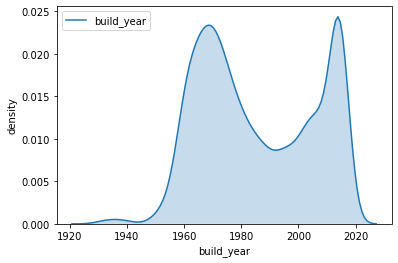

In [0]:
plot_feature_kde('build_year', 1930, 2018)

In my opnion the best option would be to Impute build_year column and keep track of Imputed values. (Otherwise we'll ruin the destribution).

In [0]:
my_build_Imputer = SimpleImputer(strategy="median")

def impute_build_year(train):
    train['build_year_was_missing'] = train[['build_year']].isnull() 
    my_build_Imputer.fit(train[['build_year']])
    train['build_year'] = my_build_Imputer.transform(train[['build_year']])

In [0]:
impute_build_year(train)

In [0]:
train.head(5)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,...,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,life_sq/full_sq,back_life_sq_ratio,life_sq/kitch_sq,back_kitch_sq_ratio,build_year_was_missing
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43.0,27.0,4.0,8.0,NaN,1981.0,NaN,16.0,NaN,Investment,Bibirevo,6.407578e+06,155572.0,0.189727,0.000070,9576.0,5001.0,5.0,10309.0,11065.0,5.0,0.0,240.0,1.0,0.0,7.0,3.0,no,0.0,16.0,1.0,no,no,no,no,no,no,no,no,...,22.0,16.0,3.0,1.0,0.0,2.0,4.0,0.0,0.0,21.0,1.0,13.09,13.31,29.0,807385.0,52.0,4036616.0,152.0,708.57,1185.71,947.14,12.0,39.0,48.0,40.0,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0,0.636364,1.571429,1.647059,0.607143,True
2,2011-08-23,34.0,19.0,3.0,8.0,NaN,1981.0,NaN,15.0,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352.0,0.372602,0.049637,6880.0,3119.0,5.0,7759.0,6237.0,8.0,0.0,229.0,1.0,0.0,6.0,1.0,yes,1.0,3.0,0.0,no,no,no,no,no,no,no,no,...,11.0,4.0,2.0,1.0,0.0,1.0,7.0,0.0,6.0,19.0,1.0,10.26,27.47,66.0,2690465.0,40.0,2034942.0,177.0,673.81,1148.81,911.31,9.0,49.0,65.0,36.0,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0,0.571429,1.750000,1.250000,0.800000,True
3,2011-08-27,43.0,29.0,2.0,8.0,NaN,1981.0,NaN,14.0,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708.0,0.112560,0.118537,5879.0,1463.0,4.0,6207.0,5580.0,7.0,0.0,1183.0,1.0,0.0,5.0,1.0,no,0.0,0.0,1.0,no,no,no,yes,no,no,no,no,...,17.0,9.0,3.0,1.0,0.0,0.0,11.0,0.0,0.0,20.0,6.0,13.69,21.58,43.0,1478160.0,35.0,1572990.0,122.0,702.68,1196.43,949.55,10.0,29.0,45.0,25.0,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0,0.681818,1.466667,2.000000,0.500000,True
4,2011-09-01,89.0,50.0,9.0,12.0,NaN,1981.0,NaN,39.0,NaN,Investment,Mitino,1.258354e+07,178473.0,0.194703,0.069753,13087.0,6839.0,9.0,13670.0,17063.0,10.0,0.0,NaN,1.0,0.0,17.0,6.0,no,0.0,11.0,4.0,no,no,no,no,no,no,no,no,...,14.0,10.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,18.0,3.0,14.18,3.89,8.0,244166.0,22.0,942180.0,61.0,931.58,1552.63,1242.11,4.0,7.0,21.0,15.0,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0,0.566667,1.764706,1.275000,0.784314,True
5,2011-09-05,77.0,77.0,4.0,8.0,NaN,1981.0,NaN,0.0,NaN,Investment,Basmannoe,8.398461e+06,108171.0,0.015234,0.037316,5706.0,3240.0,7.0,6748.0,7770.0,9.0,0.0,562.0,4.0,2.0,25.0,2.0,no,0.0,10.0,93.0,no,no,no,yes,yes,no,no,no,...,267.0,262.0,149.0,57.0,4.0,70.0,121.0,1.0,40.0,77.0,5.0,8.38,10.92,689.0,8404624.0,114.0,3503058.0,2283.0,853.88,1411.45,1132.66,143.0,566.0,578.0,552.0,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0,1.000000,1.000000,78.000000,0.012821,True


As we can see everything works correctly.